In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from folium import plugins

# Statistical analysis
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [7]:
import os

# List everything in the folder
data_path = 'D:/GIS Portfolio/Urban Mobility Analysis/'
print("All files in folder:")
for item in os.listdir(data_path):
    print(f"  - {item}")

All files in folder:
  - .ipynb_checkpoints
  - 202402-citibike-tripdata
  - 202402-citibike-tripdata.zip
  - mobility_analysis.ipynb
  - requirements.txt
  - Untitled.ipynb
  - venv


In [8]:
import pandas as pd
import glob

# Files are in a subfolder
data_path = 'D:/GIS Portfolio/Urban Mobility Analysis/202402-citibike-tripdata/'

# Try CSV first
csv_files = glob.glob(data_path + '*.csv')

if csv_files:
    print("Found CSV files:")
    trips_list = []
    for file in csv_files:
        df = pd.read_csv(file)
        trips_list.append(df)
        print(f"  Loaded: {len(df):,} trips")
    
    trips = pd.concat(trips_list, ignore_index=True)
    print(f"\nTotal: {len(trips):,} trips")
else:
    # Try Excel
    excel_files = glob.glob(data_path + '*.xlsx')
    print("Found Excel files:")
    trips_list = []
    for file in excel_files:
        df = pd.read_excel(file)
        trips_list.append(df)
        print(f"  Loaded: {len(df):,} trips")
    
    trips = pd.concat(trips_list, ignore_index=True)
    print(f"\nTotal: {len(trips):,} trips")

Found CSV files:
  Loaded: 1,000,000 trips
  Loaded: 1,000,000 trips
  Loaded: 121,501 trips

Total: 2,121,501 trips


In [9]:
# Convert timestamps
trips['started_at'] = pd.to_datetime(trips['started_at'])
trips['ended_at'] = pd.to_datetime(trips['ended_at'])

# Calculate trip duration
trips['duration_minutes'] = (trips['ended_at'] - trips['started_at']).dt.total_seconds() / 60

# Preview
print(f"Total trips: {len(trips):,}")
trips.head()

Total trips: 2,121,501


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_minutes
0,5748E600F27FCE57,classic_bike,2024-02-04 16:20:38.709,2024-02-04 16:35:35.291,W 20 St & 10 Ave,6306.01,1 Ave & E 18 St,5854.09,40.745686,-74.005141,40.733812,-73.980544,member,14.943033
1,D24A7073979DC95B,electric_bike,2024-02-07 15:41:36.819,2024-02-07 16:01:12.394,Washington St & Gansevoort St,6039.06,Schermerhorn St & Hoyt St,4479.10,40.739323,-74.008119,40.688626,-73.985191,member,19.592917
2,7112CFE937622F8F,classic_bike,2024-02-08 10:06:11.872,2024-02-08 10:08:36.614,State St & Smith St,4522.07,Schermerhorn St & Hoyt St,4479.10,40.689170,-73.988600,40.688626,-73.985191,member,2.412367
3,9F55F83B8C85D492,electric_bike,2024-02-03 08:50:04.275,2024-02-03 08:53:47.977,Brooklyn Ave & Prospect Pl,4057.04,Dean St & Franklin Ave,4107.13,40.674120,-73.944470,40.677592,-73.955637,member,3.728367
4,E19C36C9FA2F06EF,classic_bike,2024-02-06 22:22:20.967,2024-02-06 22:29:16.277,St Marks Pl & 1 Ave,5626.13,1 Ave & E 18 St,5854.09,40.727791,-73.985649,40.733812,-73.980544,member,6.921833


Missing values:
ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name    1866
start_station_id      1866
end_station_name      4768
end_station_id        4788
start_lat             1866
start_lng             1866
end_lat               4763
end_lng               4763
member_casual            0
duration_minutes         0
dtype: int64

Trip Duration Statistics:
count    2.118148e+06
mean     1.076534e+01
std      9.714274e+00
min      1.000683e+00
25%      4.765850e+00
50%      7.942975e+00
75%      1.337299e+01
max      1.199809e+02
Name: duration_minutes, dtype: float64


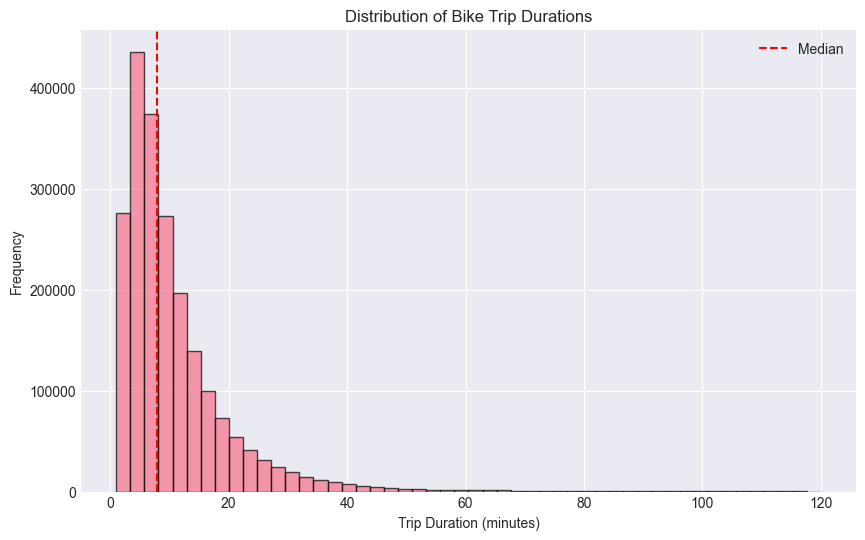

In [10]:
# Check for missing values
print("Missing values:")
print(trips.isnull().sum())

# Remove outliers (trips < 1 min or > 2 hours)
trips_clean = trips[
    (trips['duration_minutes'] >= 1) & 
    (trips['duration_minutes'] <= 120)
].copy()

# Basic statistics
print("\nTrip Duration Statistics:")
print(trips_clean['duration_minutes'].describe())

# Visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(trips_clean['duration_minutes'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Bike Trip Durations')
plt.axvline(trips_clean['duration_minutes'].median(), 
            color='red', linestyle='--', label='Median')
plt.legend()
plt.show()

In [11]:
# Create GeoDataFrame from station locations
# Assuming you have start_lat, start_lng columns

geometry = [Point(xy) for xy in zip(trips_clean['start_lng'], trips_clean['start_lat'])]
trips_geo = gpd.GeoDataFrame(trips_clean, geometry=geometry, crs='EPSG:4326')

# Station usage analysis
station_usage = trips_clean.groupby(['start_station_name', 'start_lat', 'start_lng']).agg({
    'ride_id': 'count',
    'duration_minutes': 'mean'
}).reset_index()

station_usage.columns = ['station_name', 'lat', 'lng', 'trip_count', 'avg_duration']

# Sort by usage
top_stations = station_usage.nlargest(20, 'trip_count')
print("Top 20 Busiest Stations:")
print(top_stations)

Top 20 Busiest Stations:
                 station_name        lat        lng  trip_count  avg_duration
1956          W 21 St & 6 Ave  40.741740 -73.994156        9553      9.063678
442           8 Ave & W 31 St  40.750585 -73.994685        7417     11.197641
8             1 Ave & E 68 St  40.765005 -73.958185        7365     12.446824
1378    Lafayette St & E 8 St  40.730207 -73.991026        7345      9.225121
658        Broadway & W 25 St  40.742869 -73.989186        6807     10.352150
550           Ave A & E 14 St  40.730311 -73.980472        6620      7.000686
1975          W 31 St & 7 Ave  40.749156 -73.991600        6606      9.555620
36           11 Ave & W 41 St  40.760301 -73.998842        6471      9.979685
1989          W 41 St & 8 Ave  40.756405 -73.990026        6207      9.582176
668        Broadway & W 58 St  40.766953 -73.981693        6151     11.815516
1878  University Pl & E 14 St  40.734814 -73.992085        6082      8.865616
363           6 Ave & W 33 St  40.74901

In [12]:
# Create base map centered on city
center_lat = trips_clean['start_lat'].mean()
center_lng = trips_clean['start_lng'].mean()

m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

# Add heatmap of station usage
heat_data = [[row['lat'], row['lng'], row['trip_count']] 
             for idx, row in station_usage.iterrows()]

plugins.HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(m)

# Add markers for top 10 stations
for idx, row in top_stations.head(10).iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=10,
        popup=f"{row['station_name']}<br>Trips: {row['trip_count']:,}",
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.6
    ).add_to(m)

# Save map
m.save('mobility_heatmap.html')
print("Map saved as 'mobility_heatmap.html'")

Map saved as 'mobility_heatmap.html'


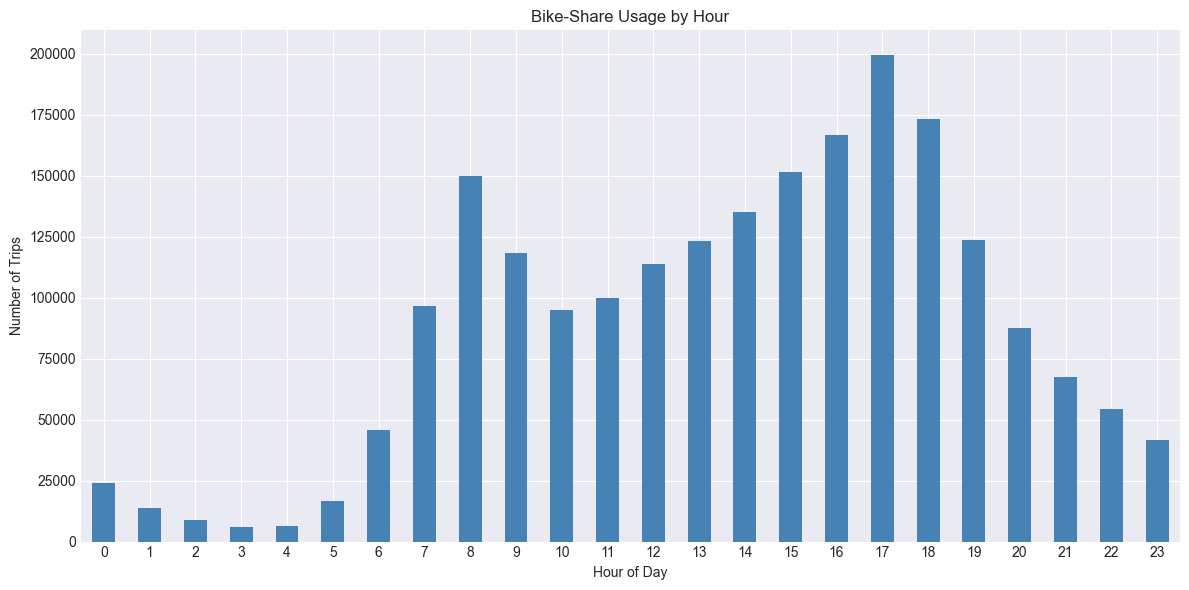

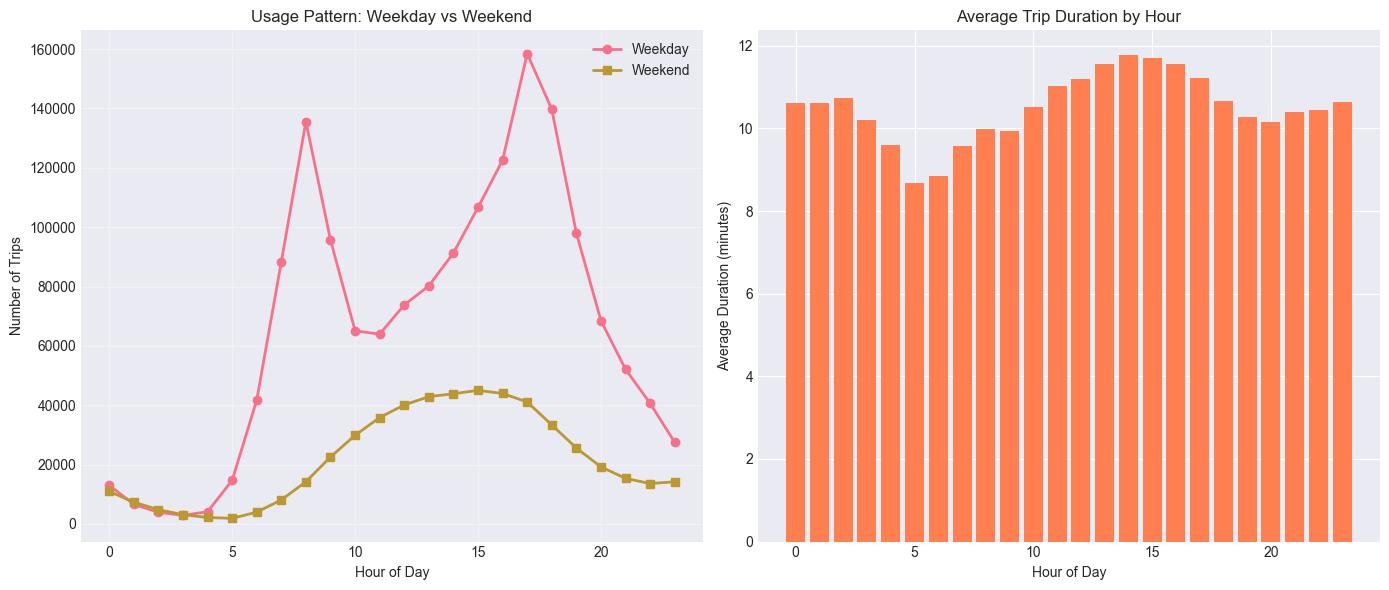

In [13]:
# Extract time features
trips_clean['hour'] = trips_clean['started_at'].dt.hour
trips_clean['day_of_week'] = trips_clean['started_at'].dt.day_name()
trips_clean['is_weekend'] = trips_clean['started_at'].dt.dayofweek >= 5

# Usage by hour
hourly_usage = trips_clean.groupby('hour').size()

plt.figure(figsize=(12, 6))
hourly_usage.plot(kind='bar', color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Bike-Share Usage by Hour')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Weekday vs Weekend comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

weekday = trips_clean[~trips_clean['is_weekend']].groupby('hour').size()
weekend = trips_clean[trips_clean['is_weekend']].groupby('hour').size()

ax[0].plot(weekday.index, weekday.values, marker='o', label='Weekday', linewidth=2)
ax[0].plot(weekend.index, weekend.values, marker='s', label='Weekend', linewidth=2)
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Number of Trips')
ax[0].set_title('Usage Pattern: Weekday vs Weekend')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Average duration by time
duration_by_hour = trips_clean.groupby('hour')['duration_minutes'].mean()
ax[1].bar(duration_by_hour.index, duration_by_hour.values, color='coral')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Average Duration (minutes)')
ax[1].set_title('Average Trip Duration by Hour')
plt.tight_layout()
plt.show()

In [14]:
# Hypothesis: Weekend trips are longer than weekday trips

weekday_durations = trips_clean[~trips_clean['is_weekend']]['duration_minutes']
weekend_durations = trips_clean[trips_clean['is_weekend']]['duration_minutes']

# T-test
t_stat, p_value = stats.ttest_ind(weekend_durations, weekday_durations)

print("Hypothesis Test: Weekend vs Weekday Trip Duration")
print(f"Weekday mean: {weekday_durations.mean():.2f} minutes")
print(f"Weekend mean: {weekend_durations.mean():.2f} minutes")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✓ Statistically significant difference (p < 0.05)")
else:
    print("✗ No statistically significant difference")

Hypothesis Test: Weekend vs Weekday Trip Duration
Weekday mean: 10.42 minutes
Weekend mean: 11.82 minutes
T-statistic: 90.9352
P-value: 0.0000
✓ Statistically significant difference (p < 0.05)



Regression Model Results:
R² Score: 0.0324
RMSE: 9.55 minutes

Feature Coefficients:
  hour: 0.0439
  day_num: -0.0156
  month: -8.9322
  is_weekend: 1.0975
  is_member: -4.9607


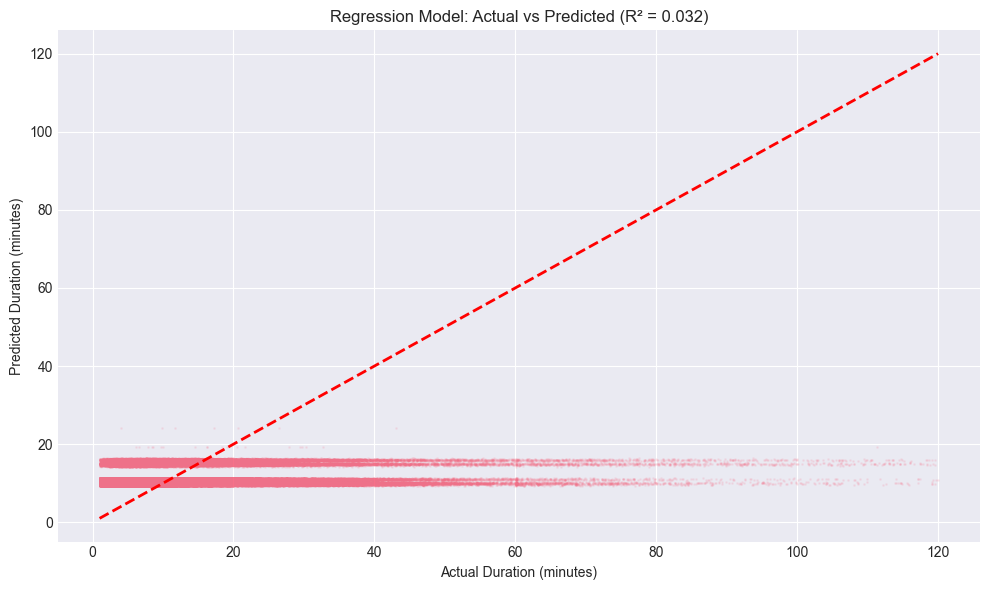

In [15]:
# Prepare data for regression: Predict trip duration
# Features: hour, day_of_week (encoded), user_type, etc.

# Feature engineering
trips_model = trips_clean.copy()
trips_model['hour'] = trips_model['started_at'].dt.hour
trips_model['day_num'] = trips_model['started_at'].dt.dayofweek
trips_model['month'] = trips_model['started_at'].dt.month

# Select features (adjust based on your data columns)
features = ['hour', 'day_num', 'month', 'is_weekend']

# If you have member_casual column:
if 'member_casual' in trips_model.columns:
    trips_model['is_member'] = (trips_model['member_casual'] == 'member').astype(int)
    features.append('is_member')

# Prepare X and y
X = trips_model[features].dropna()
y = trips_model.loc[X.index, 'duration_minutes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nRegression Model Results:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} minutes")
print("\nFeature Coefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"  {feature}: {coef:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.1, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.title(f'Regression Model: Actual vs Predicted (R² = {r2:.3f})')
plt.tight_layout()
plt.show()

In [16]:
print("=" * 60)
print("KEY FINDINGS SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Overview:")
print(f"  • Total trips analyzed: {len(trips_clean):,}")
print(f"  • Time period: {trips_clean['started_at'].min()} to {trips_clean['started_at'].max()}")
print(f"  • Unique stations: {trips_clean['start_station_name'].nunique()}")

print(f"\n🚴 Usage Patterns:")
print(f"  • Average trip duration: {trips_clean['duration_minutes'].mean():.2f} minutes")
print(f"  • Median trip duration: {trips_clean['duration_minutes'].median():.2f} minutes")
print(f"  • Peak usage hour: {hourly_usage.idxmax()}:00")

print(f"\n📈 Statistical Insights:")
print(f"  • Weekend vs Weekday difference: {abs(weekend_durations.mean() - weekday_durations.mean()):.2f} min")
print(f"  • Model R² score: {r2:.4f}")

print(f"\n🎯 Urban Planning Implications:")
print("  • [Add your interpretation here]")
print("  • [Identify accessibility gaps]")
print("  • [Policy recommendations]")

print("=" * 60)

KEY FINDINGS SUMMARY

📊 Dataset Overview:
  • Total trips analyzed: 2,118,148
  • Time period: 2024-01-31 22:48:25.745000 to 2024-02-29 23:56:05.845000
  • Unique stations: 2138

🚴 Usage Patterns:
  • Average trip duration: 10.77 minutes
  • Median trip duration: 7.94 minutes
  • Peak usage hour: 17:00

📈 Statistical Insights:
  • Weekend vs Weekday difference: 1.40 min
  • Model R² score: 0.0324

🎯 Urban Planning Implications:
  • [Add your interpretation here]
  • [Identify accessibility gaps]
  • [Policy recommendations]


In [18]:
# Save summary statistics
summary_stats = {
    'total_trips': int(len(trips_clean)),
    'avg_duration': float(trips_clean['duration_minutes'].mean()),
    'median_duration': float(trips_clean['duration_minutes'].median()),
    'top_station': str(top_stations.iloc[0]['station_name']),
    'peak_hour': int(hourly_usage.idxmax()),
    'r2_score': float(r2)
}

import json
with open('results_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

# Save top stations
top_stations.to_csv('top_20_stations.csv', index=False)

print("\n✅ Results exported successfully!")
print("  • results_summary.json")
print("  • top_20_stations.csv")
print("  • mobility_heatmap.html")


✅ Results exported successfully!
  • results_summary.json
  • top_20_stations.csv
  • mobility_heatmap.html
